In [15]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
from reachability.data.datasets import Dataset
from reachability.envs.workspace import Workspace2D
from reachability.envs.rotary_nlink import RotaryNLinkEnv
from reachability.eval.eval_model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing environment setup

(1, 6)


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=36.3° | EE Delta=0.0000'}, xlabel='X (World)', ylabel='Y (World)'>

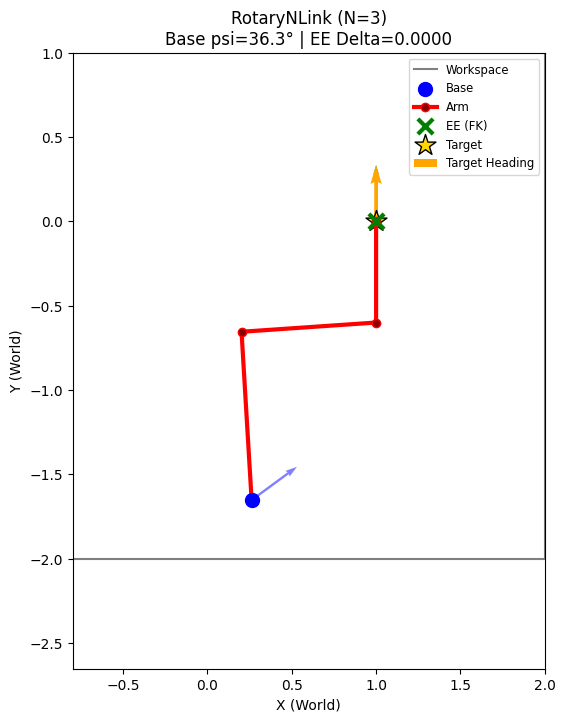

In [2]:
workspace = Workspace2D(-2, 2, -2, 2)
# link_lengths = np.array([1.0, 0.8, 0.6, 0.8, 1.0])
# joint_limits = [[[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/3, np.pi/2]], [[-np.pi/3, np.pi/2]]]
link_lengths = np.array([1.0, 0.8, 0.6])
joint_limits = [[[-np.pi/2, -np.pi/4], [np.pi/4, np.pi/2]], [[-np.pi/2, -np.pi/3], [np.pi/3, np.pi/2]], [[-np.pi, -np.pi/4], [np.pi/4, np.pi/2]]]
env = RotaryNLinkEnv(workspace, link_lengths=link_lengths, joint_limits=joint_limits, n_links=3) #joint_limits=[[-np.pi, np.pi], [-np.pi, np.pi]],

rng = np.random.default_rng(0)
h_world = np.array([[1, 0, np.pi/2]], dtype=np.float32)
q_sample_world = env.sample_q(h_world, rng)

print(q_sample_world.shape)
env.plot(q_sample_world.flatten(), h_world.flatten())

In [3]:
# Data to test on
n_samples = 2000
h_world_example = np.zeros((n_samples, 3), dtype=np.float32)

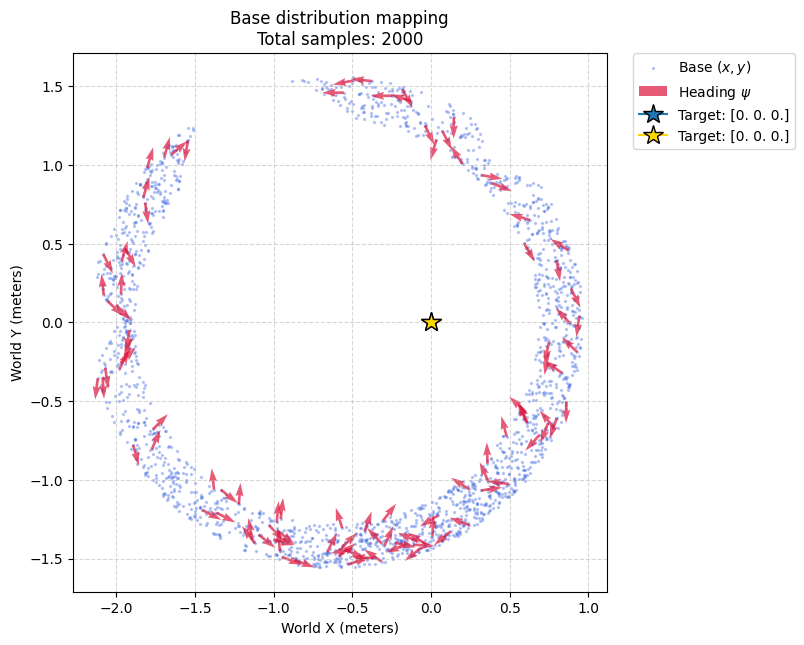

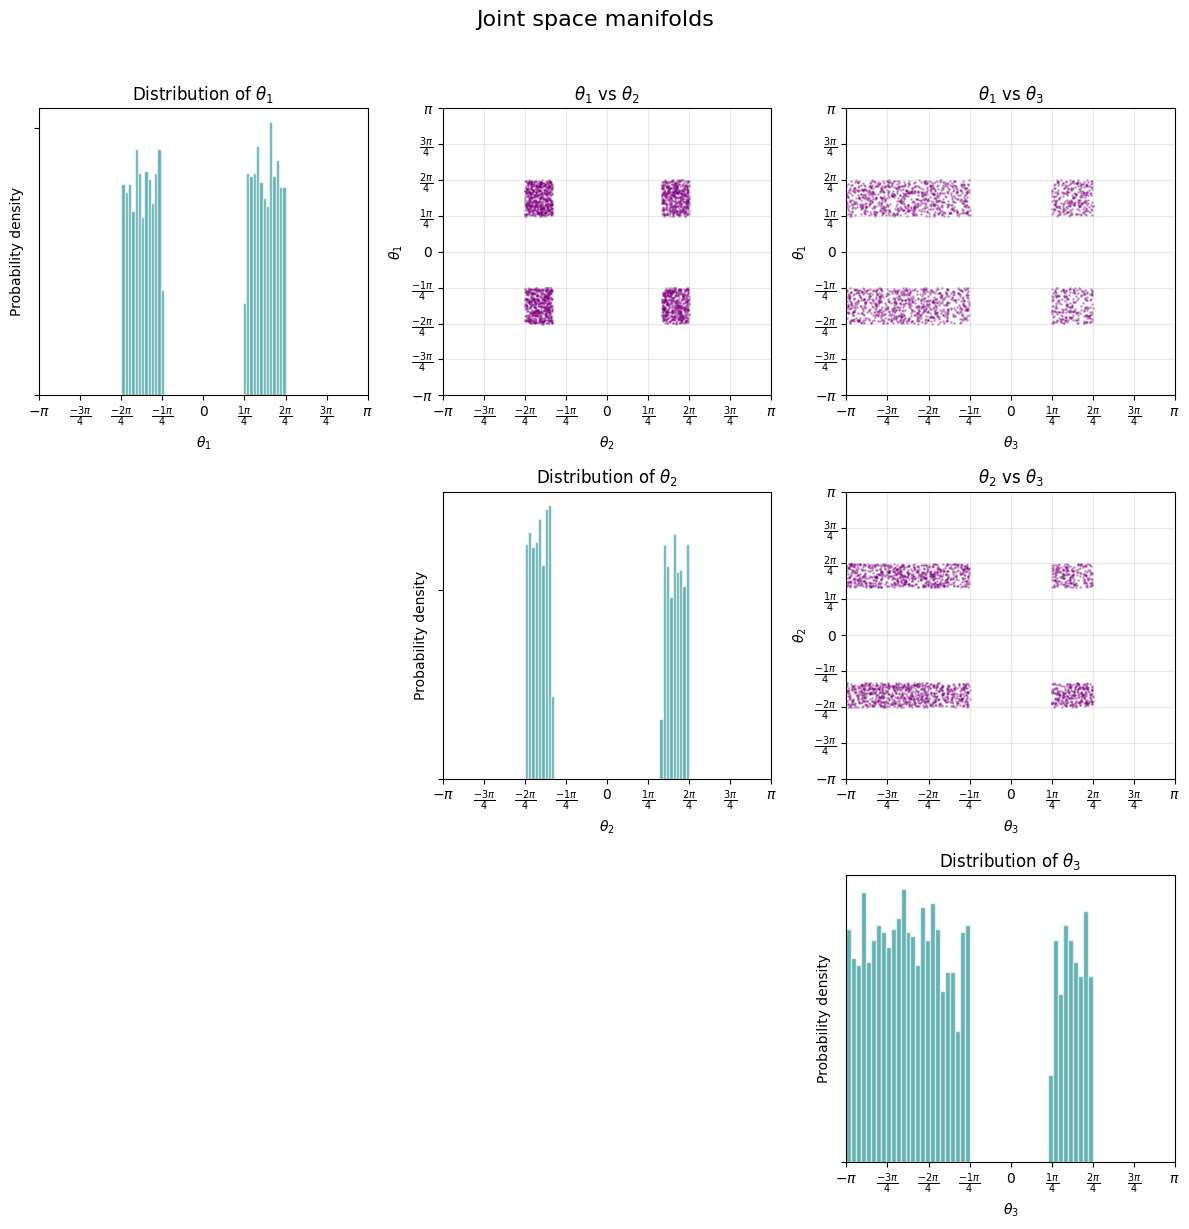

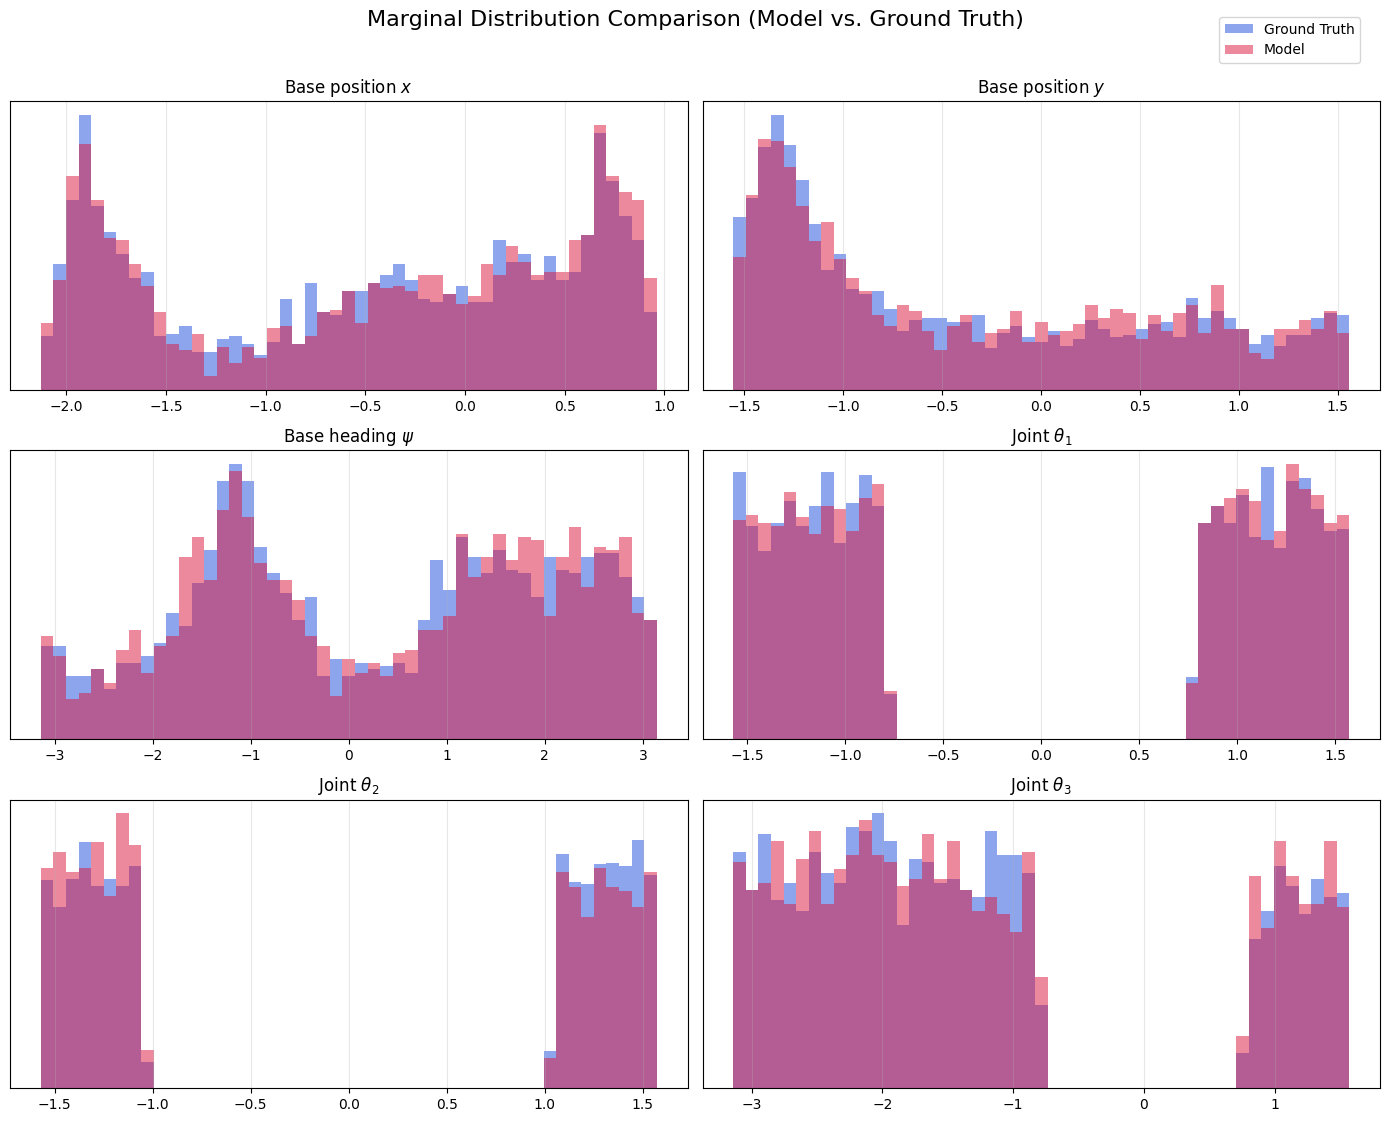

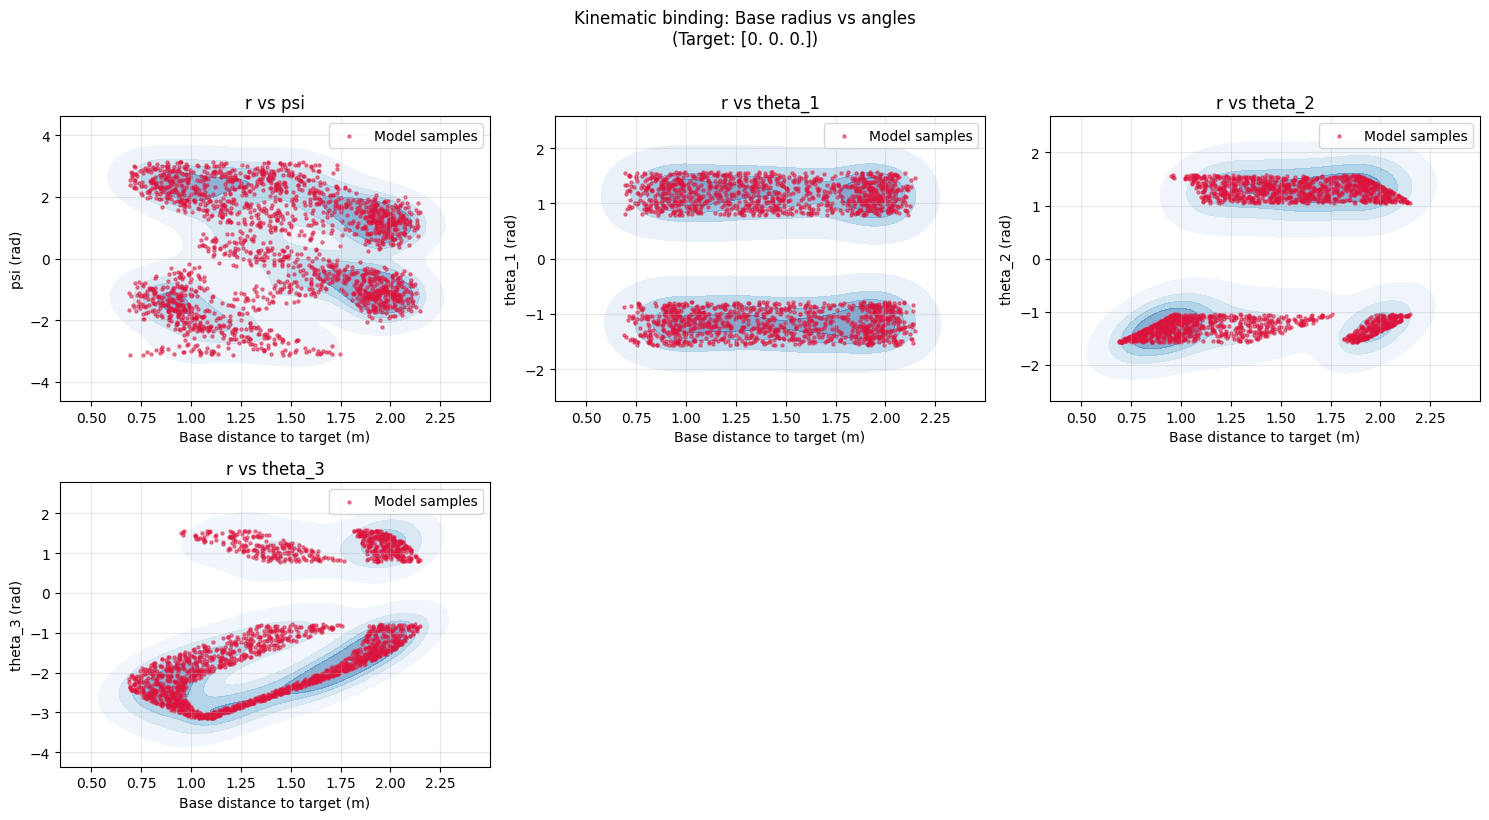

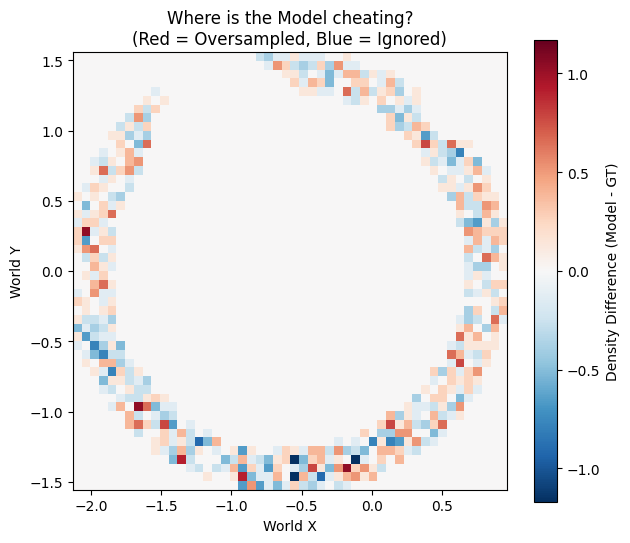

In [6]:
# 1. Generate 2000 samples for a fixed target at the origin
gt_dist = env.sample_q(h_world_example, rng)
gt_samples = env.sample_q(h_world_example, np.random.default_rng(666)) # different seed

visualize_sampled_distribution(env, q_samples=gt_samples, h_world=h_world_example[0], q_gt=gt_dist)

## Model results
### Conditional VAE

num params in encoder =  2119692
num params in decoder =  8437780
inference speed per sample (seconds):  2.37579345703125e-05


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=-26.3° | EE Delta=0.2675'}, xlabel='X (World)', ylabel='Y (World)'>

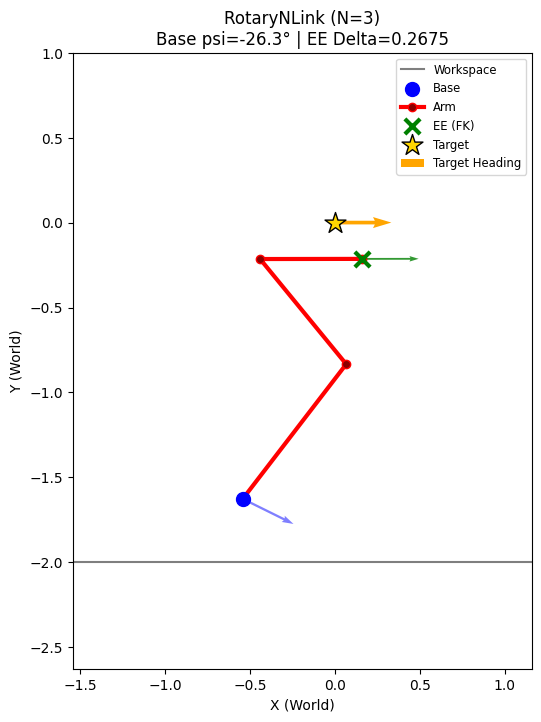

In [7]:
from reachability.models.cvae import CVAEConditionalSampler
cvae_model_path = "outputs/model_ckpts/cvae/cvae_rotaryNlink_1292026.pt"
cvae_model = CVAEConditionalSampler.load(env, cvae_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
cvae_qsamples = cvae_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng).squeeze(axis=1)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
env.plot(cvae_qsamples[0], h_world_example.flatten())

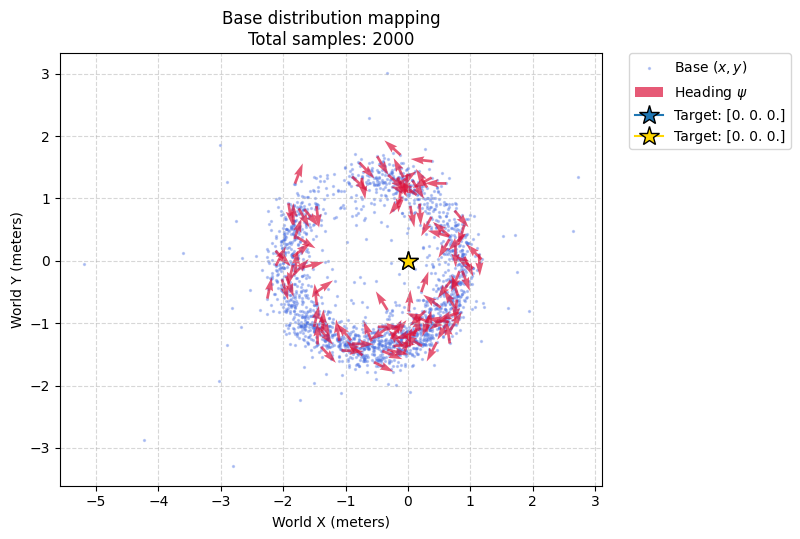

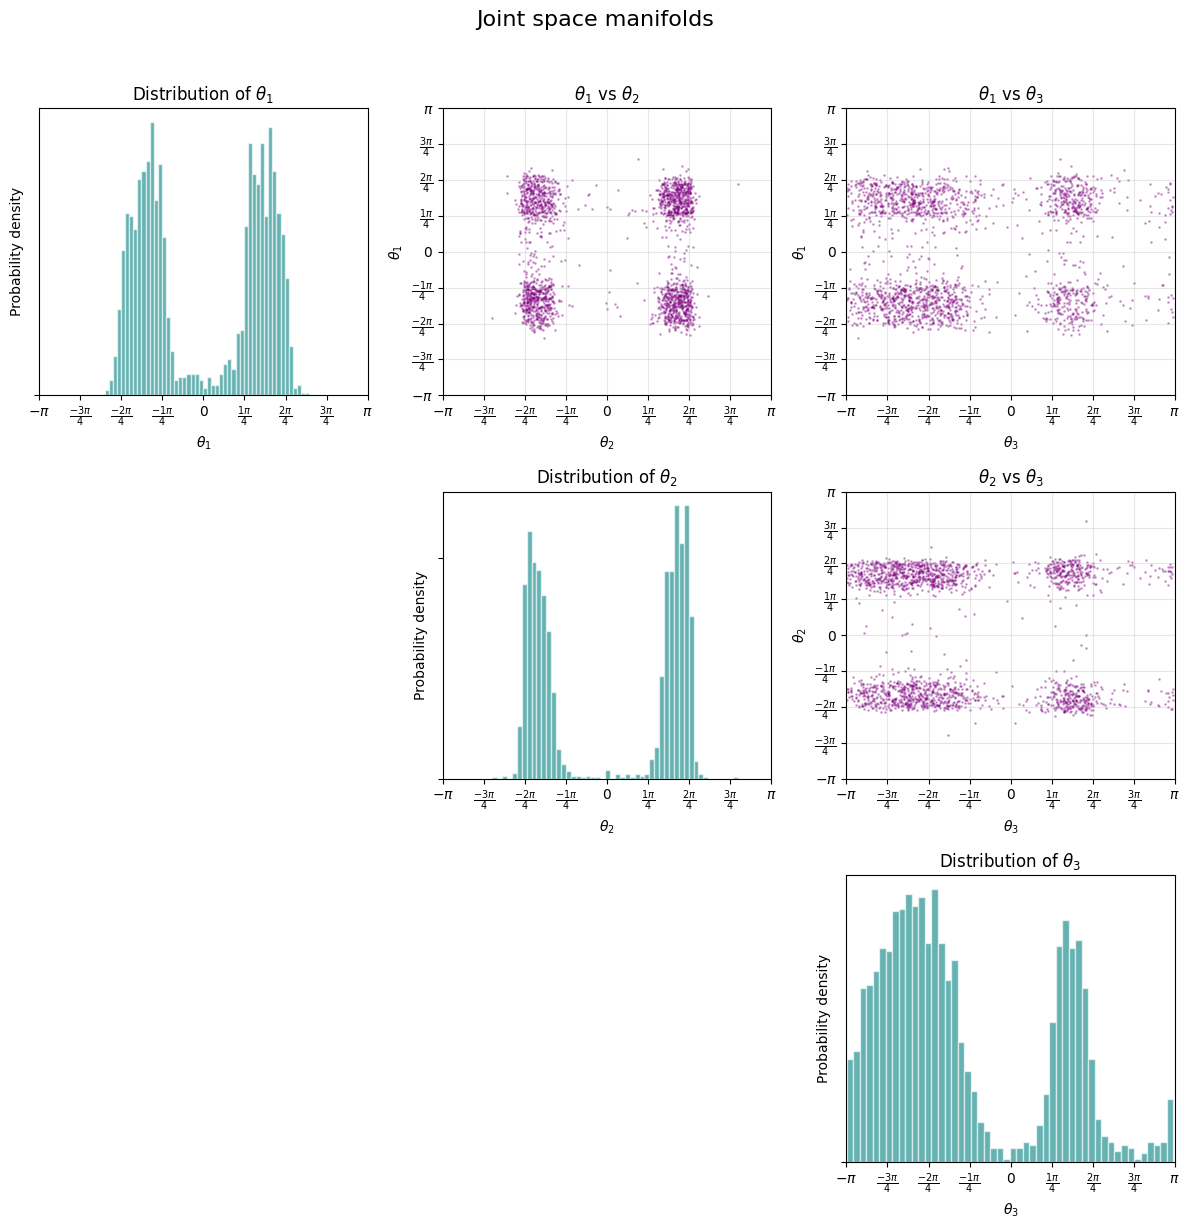

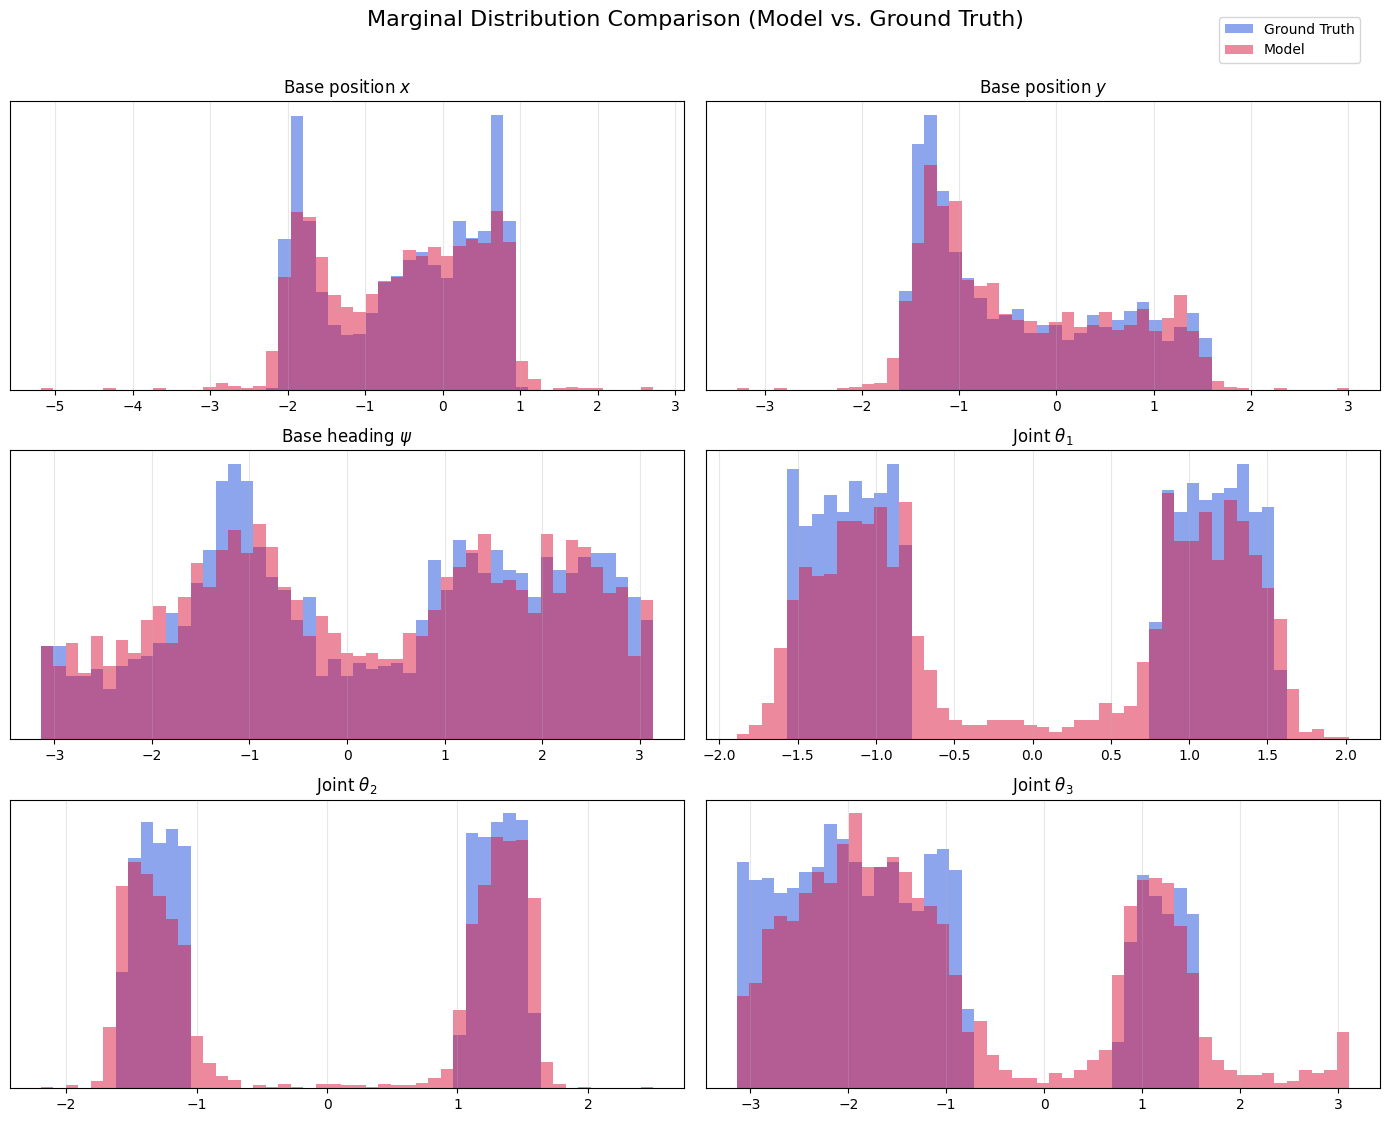

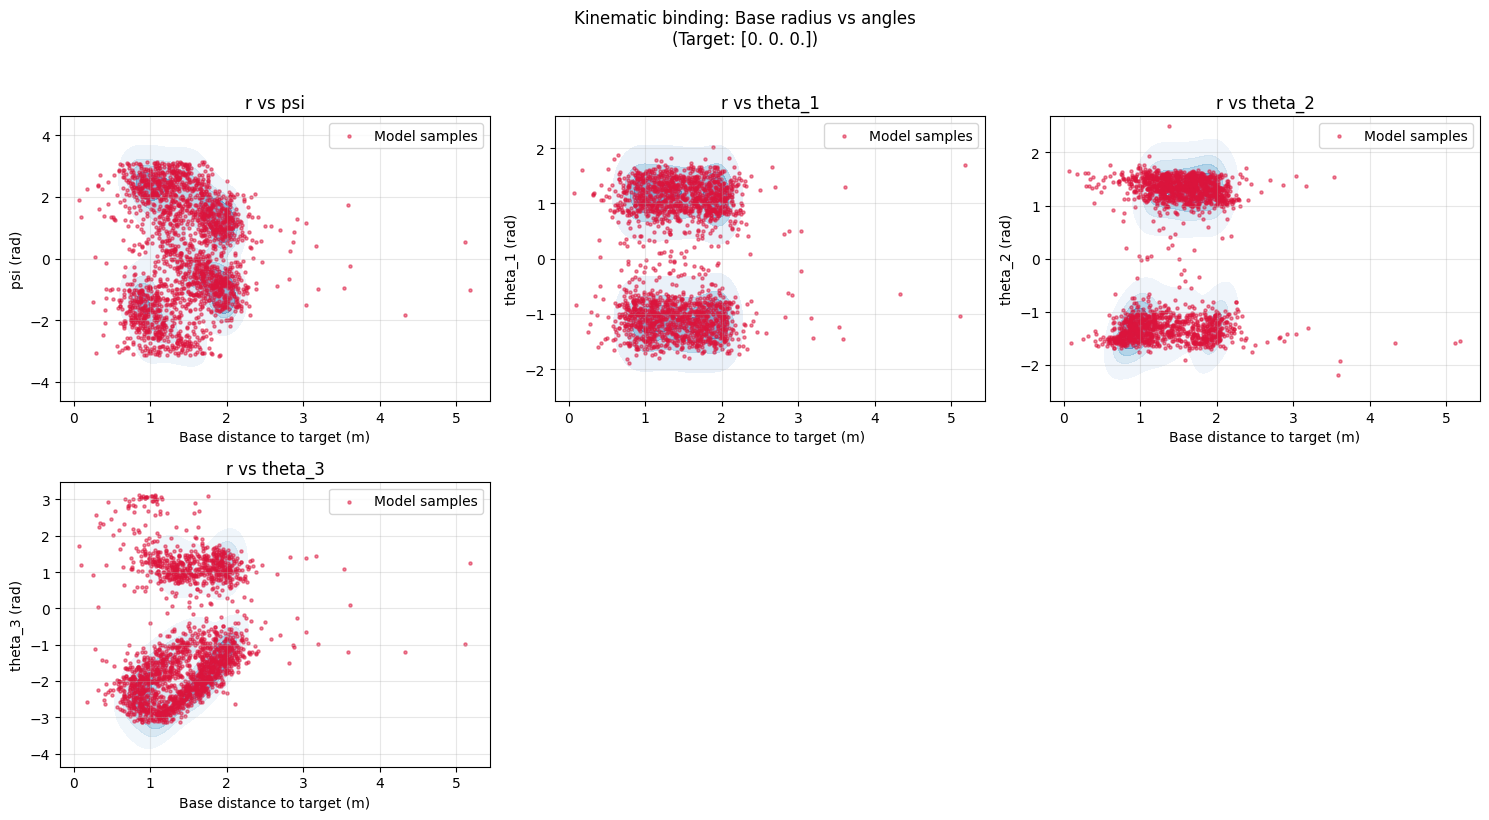

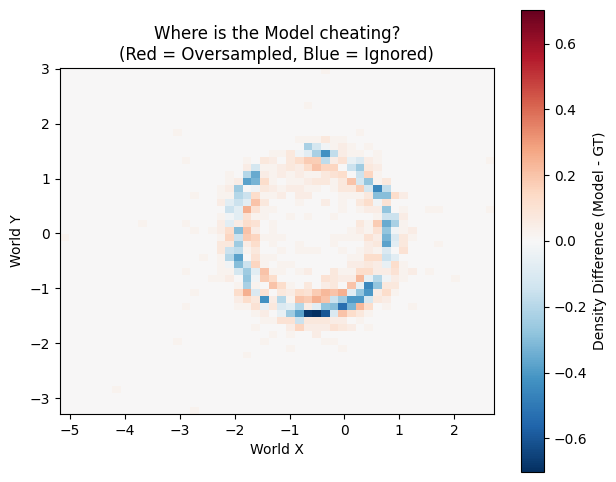

In [8]:
visualize_sampled_distribution(env, q_samples=cvae_qsamples, h_world=h_world_example[0], q_gt=gt_dist)

### Conditional INN

DEBUG: q_sample_feat.squeeze(1) shape from model: torch.Size([2000, 10])
DEBUG: q_sample_world shape after conversion: (2000, 6)
inference speed per sample (seconds):  2.929413318634033e-05


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=179.4° | EE Delta=0.0167'}, xlabel='X (World)', ylabel='Y (World)'>

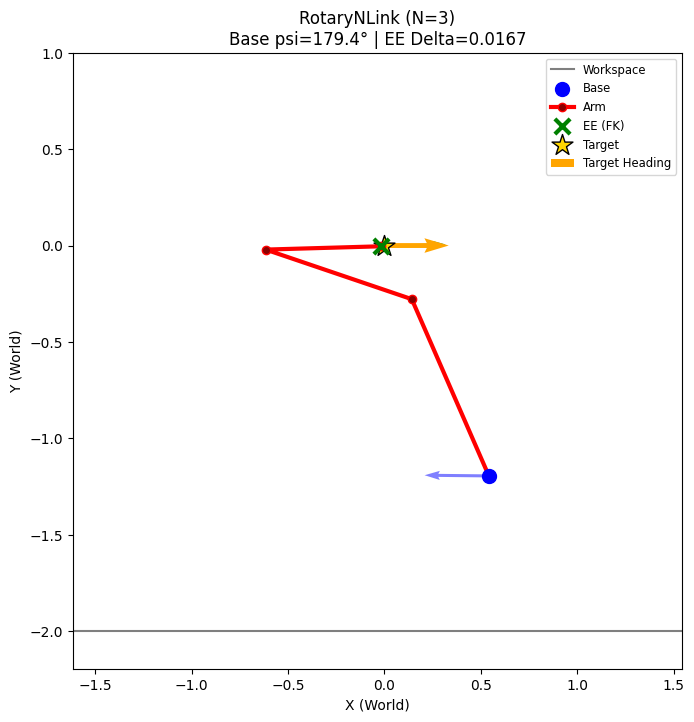

In [9]:
from reachability.models.cinn import CINNConditionalSampler
cinn_model_path = "outputs/model_ckpts/cinn/cinn_rotarynlink_1292026.pt"
cinn_model = CINNConditionalSampler.load(env, cinn_model_path, device="cpu")

# 1. Generate 2000 samples for a fixed target at the origin
start = time.time()
cinn_qsamples = cinn_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng, sampling_temperature=1).squeeze(axis=1)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
env.plot(cinn_qsamples[0].flatten(), h_world_example[0])

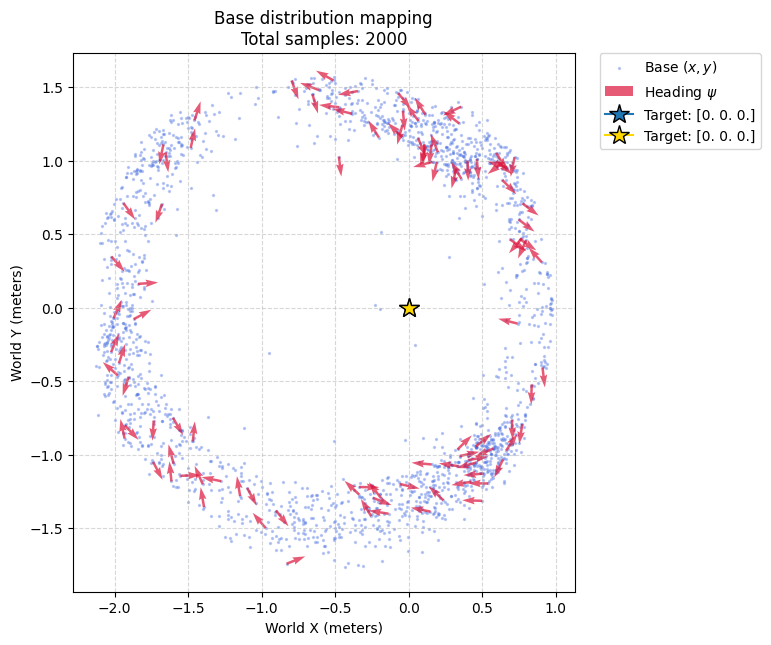

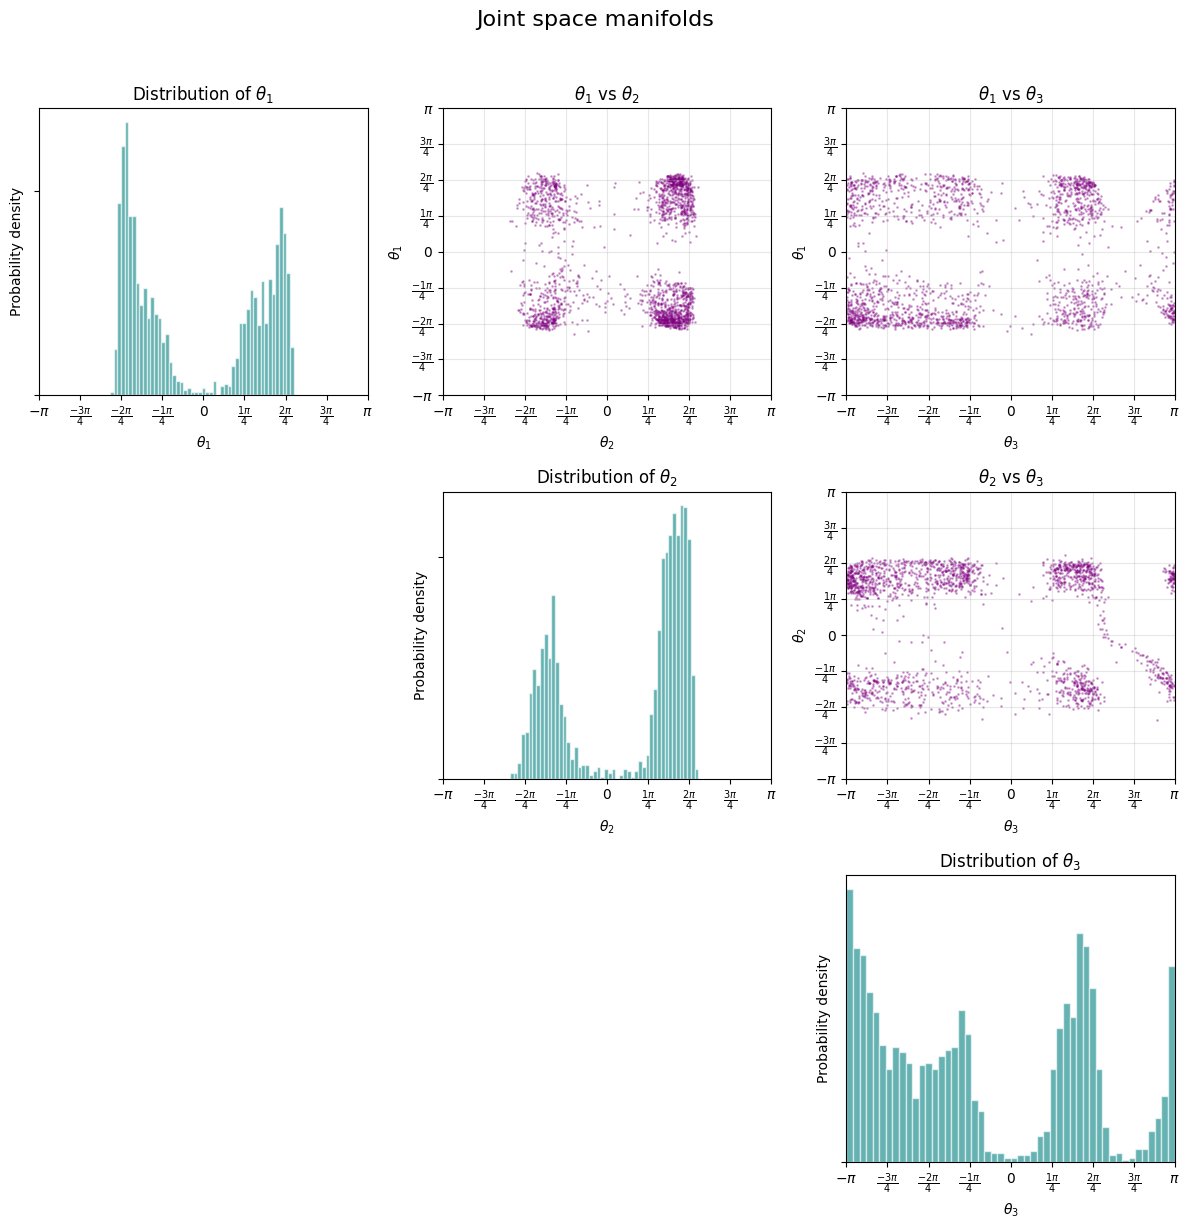

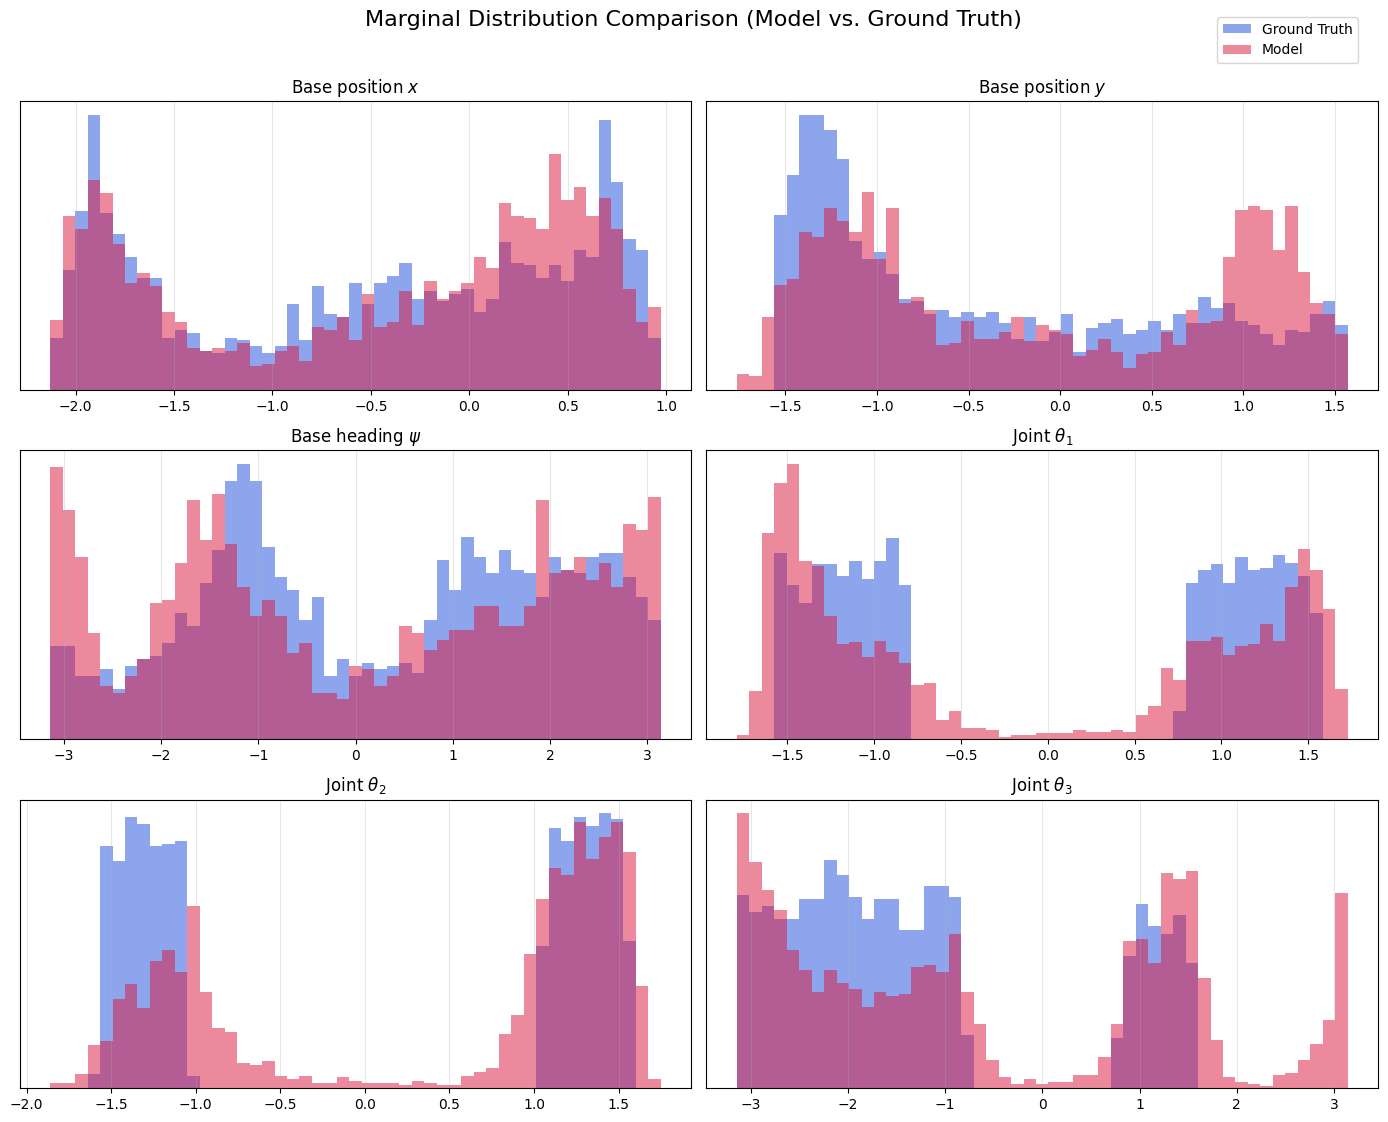

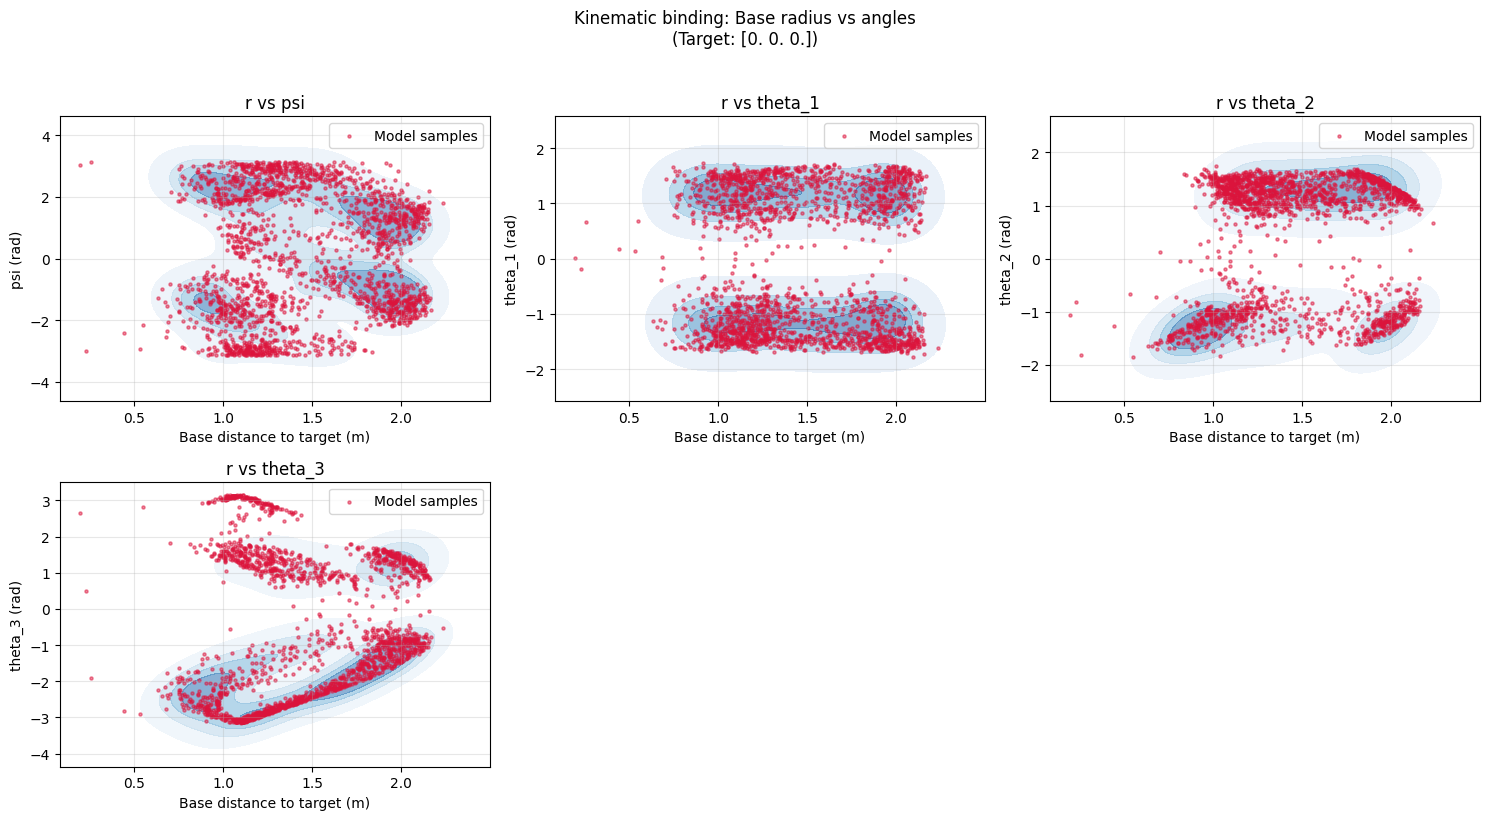

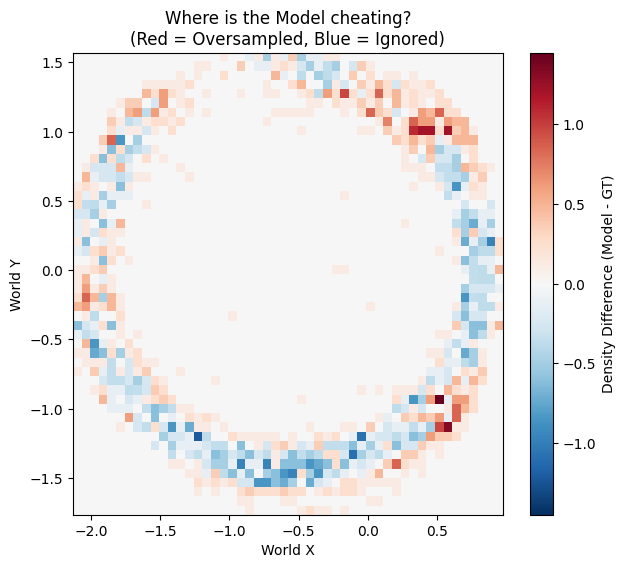

In [10]:
visualize_sampled_distribution(env, q_samples=cinn_qsamples, h_world=h_world_example[0], q_gt=gt_dist)

### Conditional diffusion

q_sample_feat shape from model: torch.Size([2000, 10])
q_sample_world shape: (2000, 6)
inference speed per sample (seconds):  0.0009215749502182007


<Axes: title={'center': 'RotaryNLink (N=3)\nBase psi=60.0° | EE Delta=0.0143'}, xlabel='X (World)', ylabel='Y (World)'>

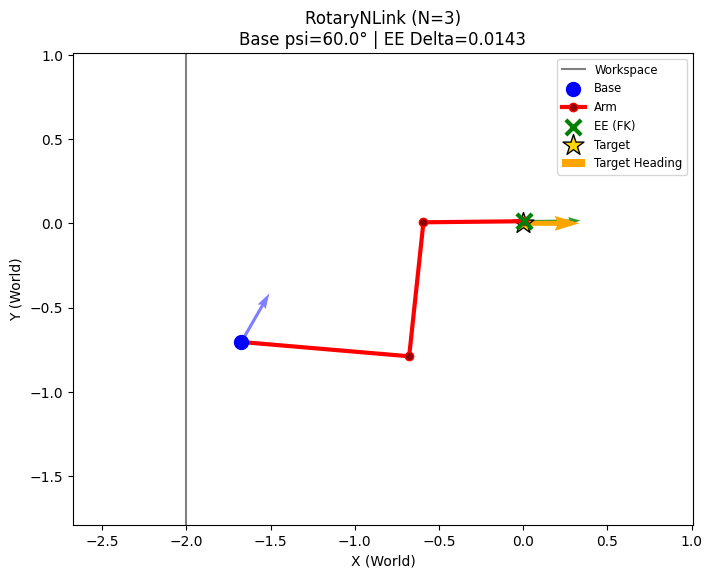

In [12]:
from reachability.models.cdiffusion import DiffusionConditionalSampler
cdiffusion_model_path = "outputs/model_ckpts/cdiffusion/cdiff_rotaryNlink_1292026.pt"
cdiffusion_model = DiffusionConditionalSampler.load(env, cdiffusion_model_path, device="cpu")

start = time.time()
cdiff_qsamples = cdiffusion_model.sample(h_world_example, h_world_example, n_samples=1, rng=rng, sampling_temperature=1).squeeze(axis=1)
print("inference speed per sample (seconds): ", (time.time() - start)/h_world_example.shape[0])
env.plot(cdiff_qsamples[0].flatten(), h_world_example[0])

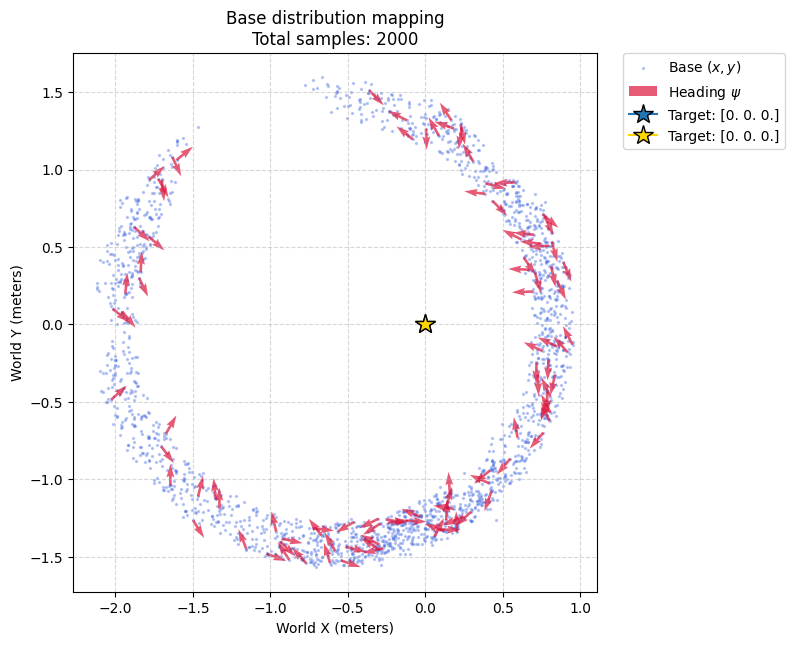

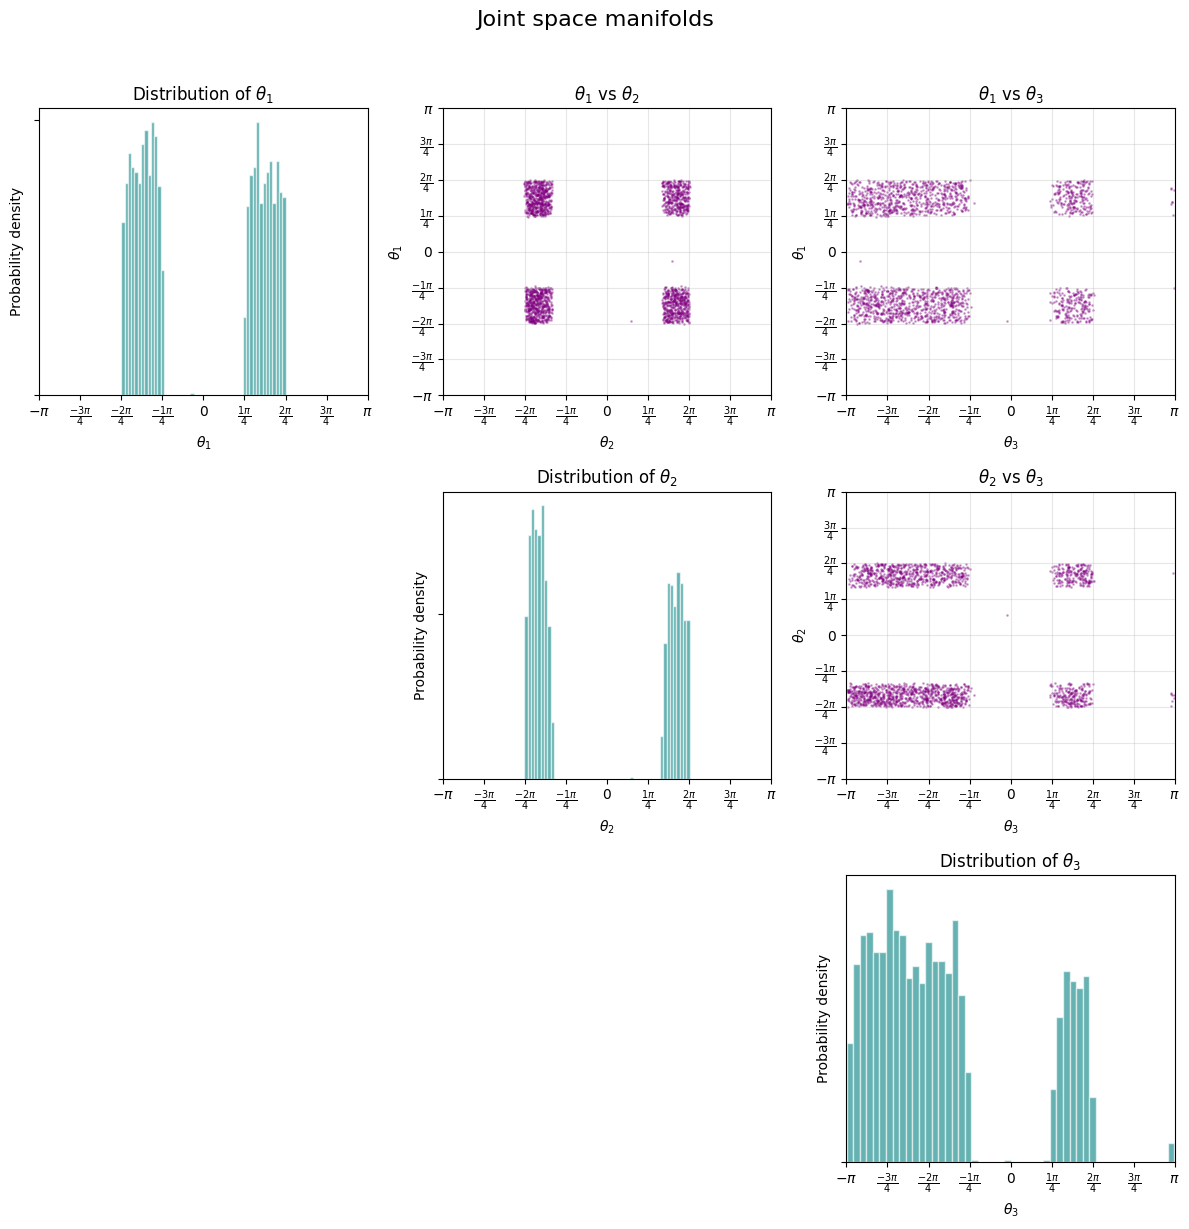

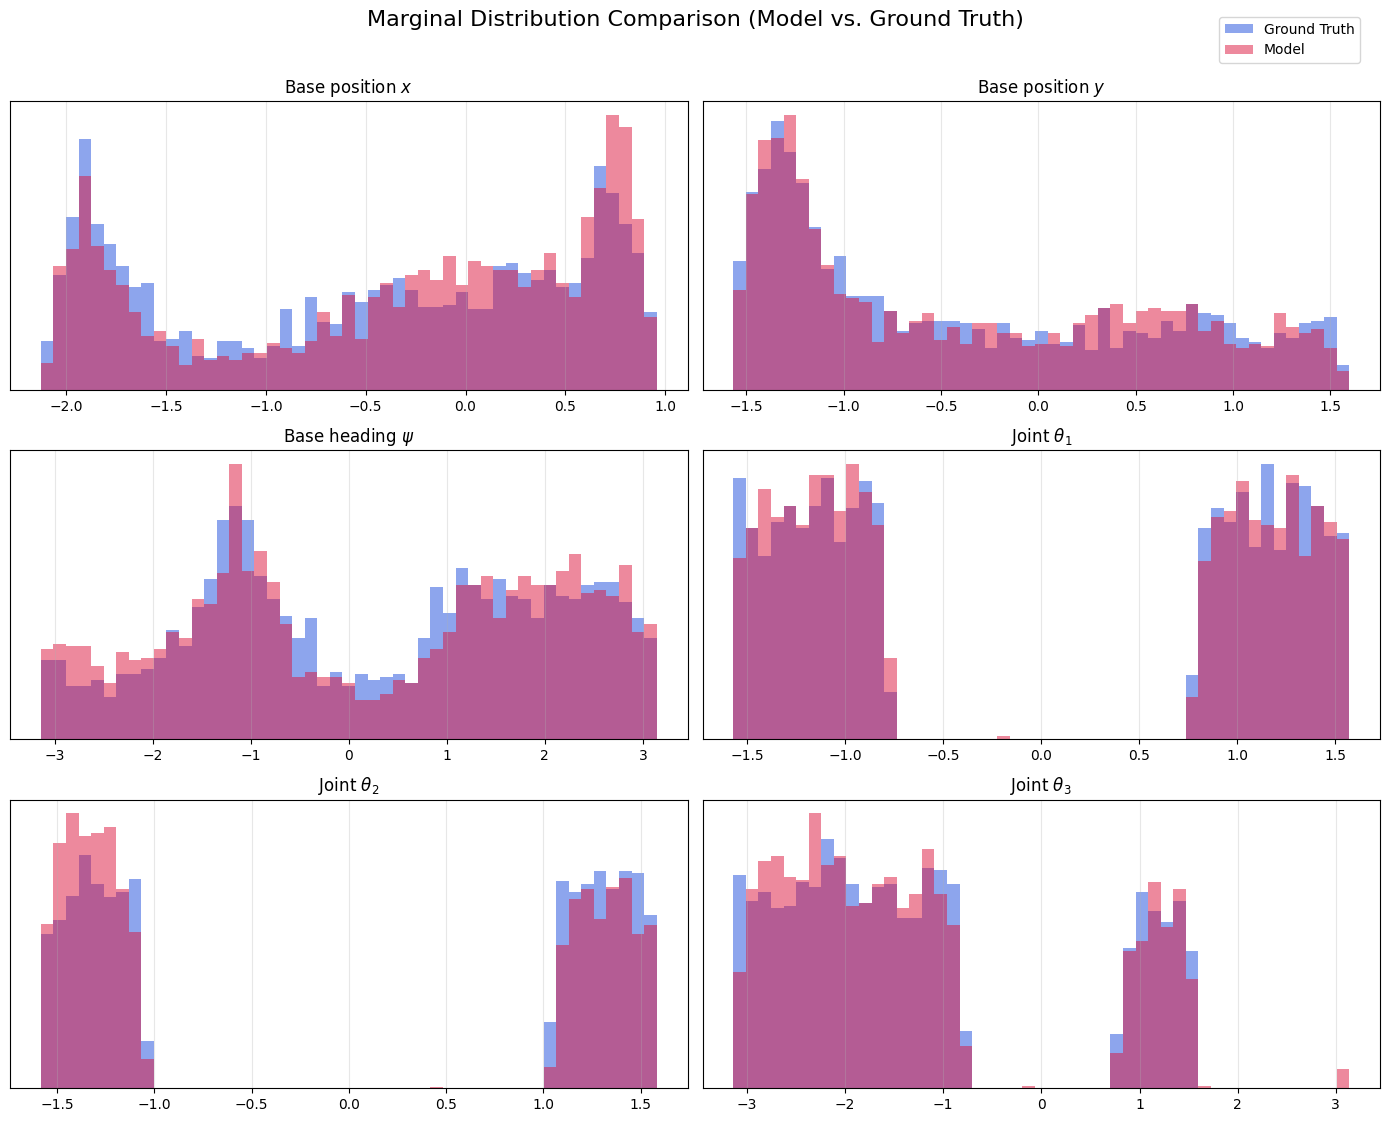

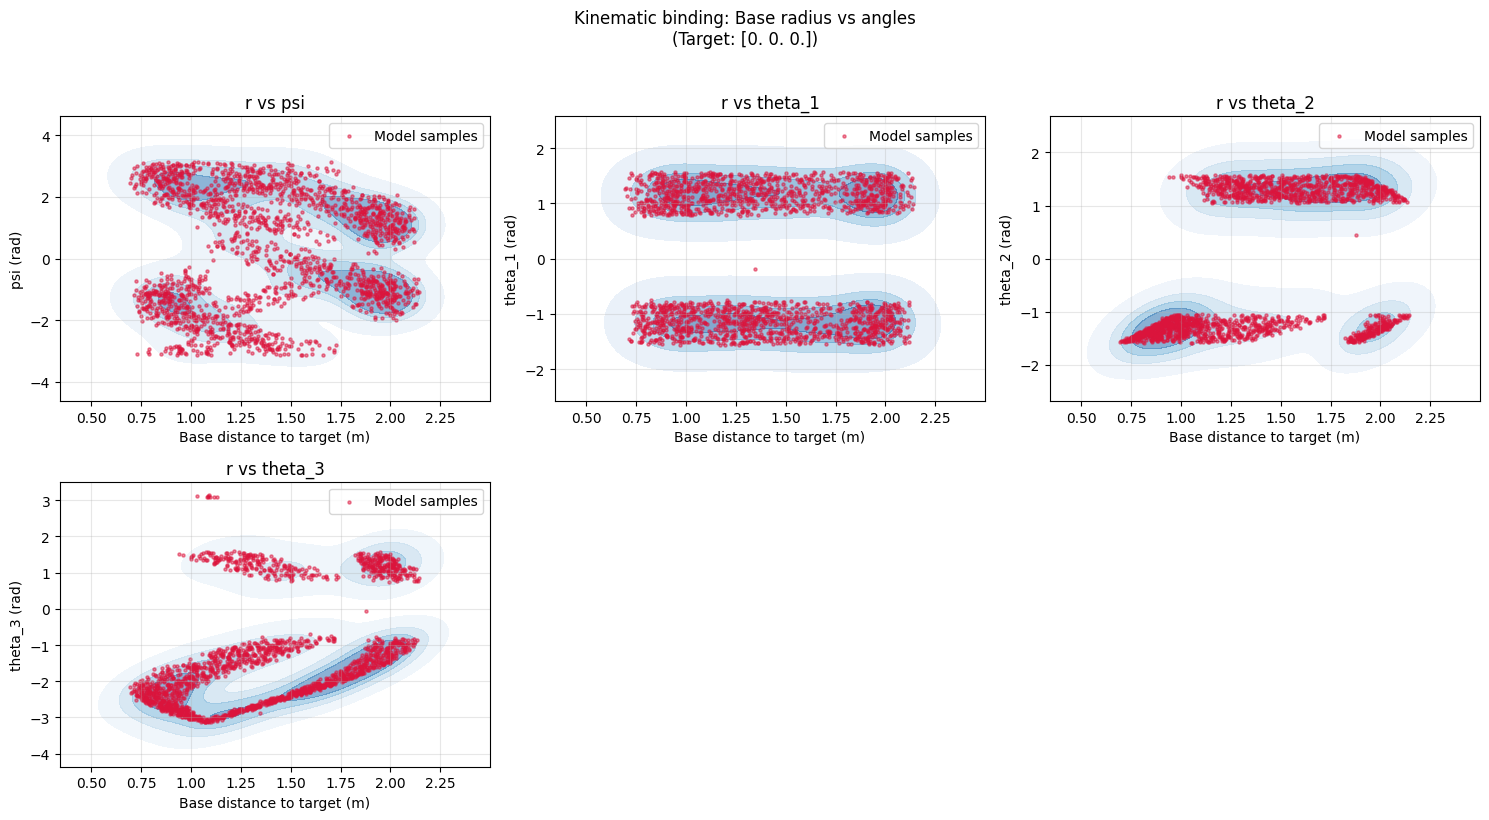

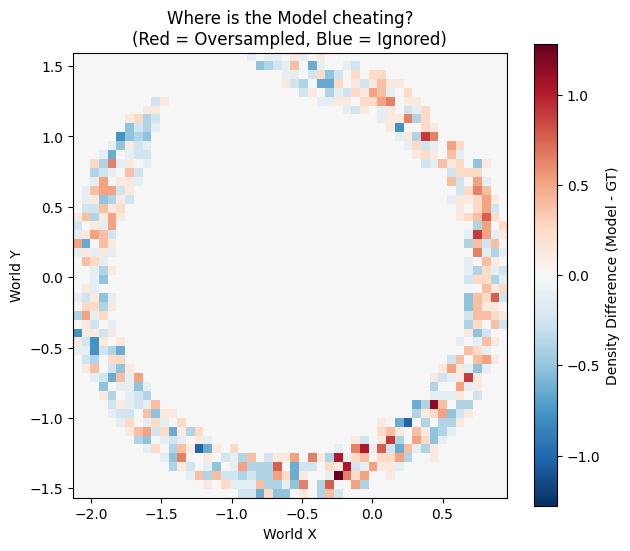

In [13]:
visualize_sampled_distribution(env, q_samples=cdiff_qsamples, h_world=h_world_example[0], q_gt=gt_dist)

## Comparing all the models -- metrics

In [14]:
print("cVAE num parameters = ", cvae_model.count_parameters())
print("cINN num paramters = ", cinn_model.count_parameters())
print("cDiffusion num parameters = ", cdiffusion_model.count_parameters())

cVAE num parameters =  10557472
cINN num paramters =  8593728
cDiffusion num parameters =  8566154


### Evaluation metrics

In [17]:
n_test = 1000
eval_config = EvalConfig(n_samples_per_h=200, n_bins_theta=72, eps_hist=1.0e-9, sampling_temperature=0)
h_world_test = Dataset.generate(env=env, n=n_test, rng=rng).h_world

In [ ]:
# Eval ground truth dist.
h_repeated = np.repeat(h_world_test, eval_config.n_samples_per_h, axis=0) # Shape: (200000, 3)
# print(h_repeated.shape)
gt_samples_flat = env.sample_q(h_repeated, rng)
gt_samples_dense = gt_samples_flat.reshape(n_test, eval_config.n_samples_per_h, -1) # Shape: (1000, 200, 6)

print(evaluate_model(env, None, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng, gt_samples_override=gt_samples_dense)) # uses seed 666 internally as the ground truth dist.

# Eval models
print(evaluate_model(env, cvae_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))
print(evaluate_model(env, cinn_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))
print(evaluate_model(env, cdiffusion_model, h_world_test=h_world_test, c_world_test=h_world_test, cfg=eval_config, rng=rng))

{'fidelity/pos_err_mean': 1.2017177652978717e-07, 'fidelity/pos_err_median': 1.1920928955078125e-07, 'fidelity/pos_err_p95': 2.6656007889869215e-07, 'hand_ori_err/mean': 2.4264394937745237e-07, 'hand_ori_err/median': 2.384185791015625e-07, 'hand_ori_err/p95': 5.960464477539062e-07, 'feasibility/collision_rate': 0.0, 'feasibility/joint_limit_rate': 0.0, 'distribution/mean_mmd': 0.21180492489039898, 'distribution/mean_emd_bearing': 0.18687194508969782, 'manifold/coverage_recall': 0.12843175588725486, 'manifold/fidelity_precision': 0.12904465857552105}
{'fidelity/pos_err_mean': 0.09908831864595413, 'fidelity/pos_err_median': 0.030885618180036545, 'fidelity/pos_err_p95': 0.4643828868865967, 'hand_ori_err/mean': 0.05601998046040535, 'hand_ori_err/median': 0.01653122901916504, 'hand_ori_err/p95': 0.24803423881530762, 'feasibility/collision_rate': 0.06631, 'feasibility/joint_limit_rate': 0.39408, 'distribution/mean_mmd': 0.21976004727184772, 'distribution/mean_emd_bearing': 0.2051083002918959

## Random testing

In [52]:
thetas.shape

(2000, 3)

In [60]:
import torch
x = np.array([0, 0, 1])
y = np.array([2, 2, 2])
print(np.concatenate([x, y]))
x = torch.Tensor(x)
y = torch.Tensor(y)
print(torch.stack([x, y], dim=-1))

[0 0 1 2 2 2]
tensor([[0., 2.],
        [0., 2.],
        [1., 2.]])
